In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import matplotlib.pyplot as plt
import numpy as np
import os
import pathlib

try:
    import kagglehub
    KAGGLEHUB_AVAILABLE = True
    print("KaggleHub: Available")
except ImportError:
    KAGGLEHUB_AVAILABLE = False
    print("KaggleHub: Not available - Install dengan: pip install kagglehub")

print(f"TensorFlow version: {tf.__version__}")
print("GPU Available: ", tf.config.list_physical_devices('GPU'))

print("\n" + "="*50)
print("SETUP KAGGLE CREDENTIALS (jika belum)")
print("="*50)
print("Jika ini pertama kali pakai kagglehub:")
print("1. Login ke Kaggle.com")
print("2. Go to Account -> API -> Create New Token")
print("3. Download kaggle.json")
print("4. Letakkan di:")
print("   - Windows: C:\\Users\\[username]\\.kaggle\\kaggle.json")
print("   - Linux/Mac: ~/.kaggle/kaggle.json")
print("5. Atau set environment variable KAGGLE_USERNAME dan KAGGLE_KEY")
print("="*50)


KaggleHub: Available
TensorFlow version: 2.15.0
GPU Available:  []

SETUP KAGGLE CREDENTIALS (jika belum)
Jika ini pertama kali pakai kagglehub:
1. Login ke Kaggle.com
2. Go to Account -> API -> Create New Token
3. Download kaggle.json
4. Letakkan di:
   - Windows: C:\Users\[username]\.kaggle\kaggle.json
   - Linux/Mac: ~/.kaggle/kaggle.json
5. Atau set environment variable KAGGLE_USERNAME dan KAGGLE_KEY


In [2]:
# ============================================
# 2. DOWNLOAD & SETUP DATASET
CUSTOM_DATASET_ROOT = "D:/classification-images/dataset" 

os.makedirs(CUSTOM_DATASET_ROOT, exist_ok=True)
os.environ['KAGGLEHUB_CACHE'] = CUSTOM_DATASET_ROOT
print(f"Dataset akan disimpan di: {CUSTOM_DATASET_ROOT}")
DATASET_SLUG = "puneet6060/intel-image-classification"
os.makedirs(CUSTOM_DATASET_ROOT, exist_ok=True)

# Download dataset menggunakan kagglehub
try:
    import kagglehub
    path = kagglehub.dataset_download(DATASET_SLUG)
    
    print(f"\nDataset berhasil didownload!")
    print(f"Lokasi dataset: {path}")
    
    # Verifikasi apakah di drive D
    if path.startswith('D:') or path.startswith('d:'):
        print(f"Dataset tersimpan di drive D (custom location)")
    else:
        print(f"INFO: Dataset di-cache di lokasi default sistem")
        print(f"Untuk force ke D:, restart kernel dan jalankan ulang")
        print(f"Atau dataset akan tetap berfungsi dari lokasi ini")
    
    # Auto-detect struktur folder yang benar
    print("\nMencari struktur folder dataset...")
    
    def find_dataset_folder(base_path):
        """Cari folder yang berisi struktur class/images"""
        
        # Fungsi untuk cek apakah folder valid (berisi class folders dengan images)
        def has_image_classes(check_path):
            try:
                items = os.listdir(check_path)
                class_dirs = [d for d in items if os.path.isdir(os.path.join(check_path, d))]
                
                if len(class_dirs) < 3:  # Minimal 3 kelas
                    return False
                
                # Cek apakah ada gambar di dalam class folders
                for class_dir in class_dirs[:3]:  # Cek 3 folder pertama
                    class_path = os.path.join(check_path, class_dir)
                    try:
                        files = os.listdir(class_path)
                        if any(f.lower().endswith(('.jpg', '.jpeg', '.png')) for f in files):
                            return True
                    except:
                        continue
                return False
            except:
                return False
        
        # Cek path langsung
        if has_image_classes(base_path):
            return base_path
        
        # Cari di subdirectories (max depth 3)
        for root, dirs, files in os.walk(base_path):
            depth = root[len(base_path):].count(os.sep)
            if depth < 3:  # Limit depth
                if has_image_classes(root):
                    return root
        
        return None
    
    DATASET_PATH = find_dataset_folder(path)
    
    if DATASET_PATH is None:
        print(f"ERROR: Tidak dapat menemukan struktur dataset yang valid di {path}")
        print("\nStruktur folder yang ditemukan:")
        for root, dirs, files in os.walk(path):
            level = root.replace(path, '').count(os.sep)
            if level < 3:
                indent = ' ' * 2 * level
                print(f"{indent}{os.path.basename(root)}/")
        raise FileNotFoundError("Dataset structure tidak valid")
    else:
        print(f"Struktur dataset ditemukan!")
        print(f"Path: {DATASET_PATH}")
    
except ImportError:
    print("\nERROR: kagglehub tidak terinstall!")
    print("Install dengan: pip install kagglehub")
    raise
    
except Exception as e:
    print(f"\nERROR saat download: {e}")
    print("\nJika error autentikasi Kaggle:")
    print("1. Login ke Kaggle.com")
    print("2. Go to Account -> API -> Create New Token")
    print("3. Download kaggle.json")
    print("4. Windows: Taruh di C:\\Users\\[username]\\.kaggle\\kaggle.json")
    print("5. Linux/Mac: Taruh di ~/.kaggle/kaggle.json")
    print("\nAtau set environment variable:")
    print("import os")
    print("os.environ['KAGGLE_USERNAME'] = 'your_username'")
    print("os.environ['KAGGLE_KEY'] = 'your_key'")
    raise

# Validasi path
if not os.path.exists(DATASET_PATH):
    print(f"\nERROR: Path tidak ditemukan: {DATASET_PATH}")
    print("\nCek struktur folder dengan:")
    print(f"import os")
    print(f"for root, dirs, files in os.walk('{path}'):")
    print(f"    print(root)")
    raise FileNotFoundError(f"Dataset path tidak valid: {DATASET_PATH}")

data_dir = pathlib.Path(DATASET_PATH)

# Hitung jumlah gambar
image_extensions = ['*.jpg', '*.jpeg', '*.png', '*.JPG', '*.JPEG', '*.PNG']
image_count = sum(len(list(data_dir.glob(f'*/{ext}'))) for ext in image_extensions)

# Dapatkan daftar kelas
classes = sorted([item.name for item in data_dir.iterdir() if item.is_dir()])
num_classes = len(classes)

print(f"\nDataset ditemukan!")
print(f"Location: {DATASET_PATH}")
print(f"Total gambar: {image_count:,}")
print(f"Jumlah kelas: {num_classes}")
print(f"Kelas: {classes[:10]}{'...' if len(classes) > 10 else ''}")

Dataset akan disimpan di: D:/classification-images/dataset

Dataset berhasil didownload!
Lokasi dataset: D:/classification-images/dataset\datasets\puneet6060\intel-image-classification\versions\2
Dataset tersimpan di drive D (custom location)

Mencari struktur folder dataset...
Struktur dataset ditemukan!
Path: D:/classification-images/dataset\datasets\puneet6060\intel-image-classification\versions\2\seg_test\seg_test

Dataset ditemukan!
Location: D:/classification-images/dataset\datasets\puneet6060\intel-image-classification\versions\2\seg_test\seg_test
Total gambar: 6,000
Jumlah kelas: 6
Kelas: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


In [3]:
# ============================================
# 3. PARAMETER DAN KONFIGURASI
# ============================================
IMG_HEIGHT = 160  # Reduced dari 224 untuk training lebih cepat
IMG_WIDTH = 160
BATCH_SIZE = 64  # Increased dari 32 untuk lebih cepat
EPOCHS = 25  # Reduced dari 50, dengan early stopping akan lebih cepat

print(f"\nKonfigurasi Model:")
print(f"- Image size: {IMG_HEIGHT}x{IMG_WIDTH}")
print(f"- Batch size: {BATCH_SIZE}")
print(f"- Max epochs: {EPOCHS}")
print(f"- Jumlah kelas: {num_classes}")
print(f"- Strategy: Transfer Learning (MobileNetV2) untuk training cepat")


Konfigurasi Model:
- Image size: 160x160
- Batch size: 64
- Max epochs: 25
- Jumlah kelas: 6
- Strategy: Transfer Learning (MobileNetV2) untuk training cepat


In [4]:
# ============================================
# 4. DATA PREPARATION - MANUAL SPLIT
# ============================================
print("\n" + "="*50)
print("MANUAL DATA SPLIT")
print("="*50)

# Gabungkan semua gambar dari seg_train dan seg_test
print("Menggabungkan dataset dari seg_train dan seg_test...")

all_image_paths = []
all_labels = []

# Collect dari seg_train
train_base = os.path.dirname(DATASET_PATH)
train_path = DATASET_PATH

# Collect dari seg_test
test_path = train_path.replace('seg_train', 'seg_test')

# Function untuk collect images
def collect_images(base_path, classes):
    paths = []
    labels = []
    for class_idx, class_name in enumerate(classes):
        class_dir = os.path.join(base_path, class_name)
        if os.path.exists(class_dir):
            for img_file in os.listdir(class_dir):
                if img_file.lower().endswith(('.jpg', '.jpeg', '.png')):
                    paths.append(os.path.join(class_dir, img_file))
                    labels.append(class_idx)
    return paths, labels

# Collect dari train
train_paths, train_labels = collect_images(train_path, classes)
print(f"Dari seg_train: {len(train_paths)} gambar")

# Collect dari test
test_paths, test_labels = collect_images(test_path, classes)
print(f"Dari seg_test: {len(test_paths)} gambar")

# Gabung semua
all_image_paths = train_paths + test_paths
all_labels = train_labels + test_labels
print(f"Total gabungan: {len(all_image_paths)} gambar")

# Split manual dengan stratified
from sklearn.model_selection import train_test_split

# Split 1: Train (70%) vs Temp (30%)
train_paths, temp_paths, train_labels, temp_labels = train_test_split(
    all_image_paths, all_labels,
    test_size=0.3,
    stratify=all_labels,
    random_state=42
)

# Split 2: Validation (15%) vs Test (15%)
val_paths, test_paths, val_labels, test_labels = train_test_split(
    temp_paths, temp_labels,
    test_size=0.5,
    stratify=temp_labels,
    random_state=42
)

print(f"\nPembagian Manual:")
print(f"Training: {len(train_paths)} gambar")
print(f"Validation: {len(val_paths)} gambar")
print(f"Test: {len(test_paths)} gambar")

# Create generators dari file paths
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd

# Create dataframes
train_df = pd.DataFrame({'filename': train_paths, 'class': [classes[l] for l in train_labels]})
val_df = pd.DataFrame({'filename': val_paths, 'class': [classes[l] for l in val_labels]})
test_df = pd.DataFrame({'filename': test_paths, 'class': [classes[l] for l in test_labels]})

# Data augmentation untuk training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1
)

# No augmentation untuk val/test
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Create generators
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='filename',
    y_col='class',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_test_datagen.flow_from_dataframe(
    val_df,
    x_col='filename',
    y_col='class',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator = val_test_datagen.flow_from_dataframe(
    test_df,
    x_col='filename',
    y_col='class',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Save class indices for later use
class_indices = train_generator.class_indices
class_names_dict = {v: k for k, v in class_indices.items()}


MANUAL DATA SPLIT
Menggabungkan dataset dari seg_train dan seg_test...
Dari seg_train: 3000 gambar
Dari seg_test: 3000 gambar
Total gabungan: 6000 gambar

Pembagian Manual:
Training: 4200 gambar
Validation: 900 gambar
Test: 900 gambar
Found 4200 validated image filenames belonging to 6 classes.
Found 900 validated image filenames belonging to 6 classes.
Found 900 validated image filenames belonging to 6 classes.


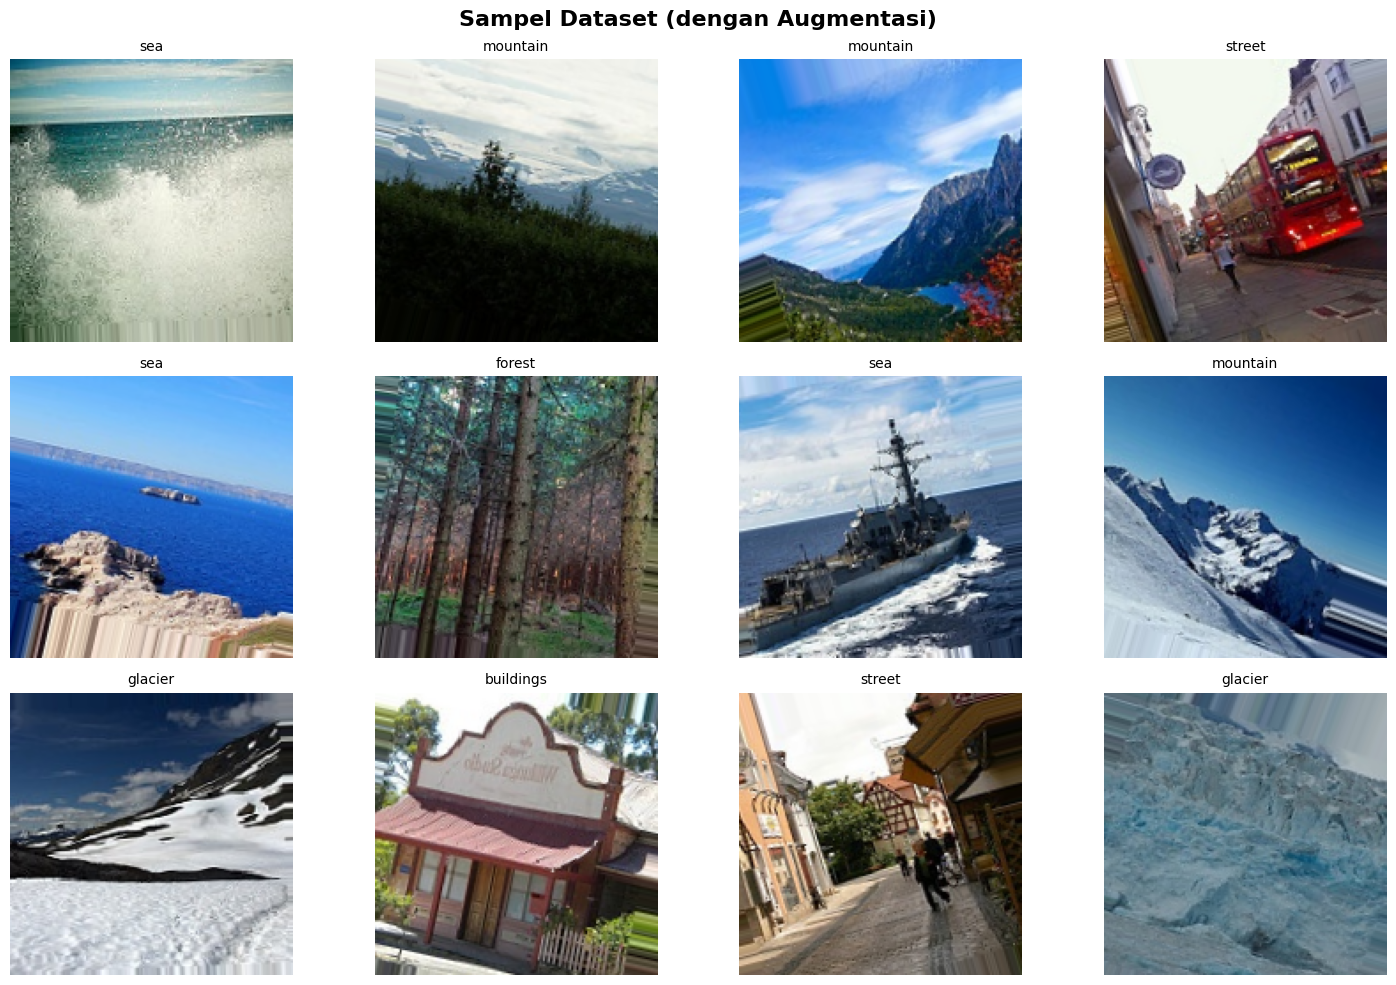

Visualisasi disimpan sebagai 'sample_dataset.png'


In [5]:
# ============================================
# 5. VISUALISASI SAMPEL DATA
# ============================================

plt.figure(figsize=(15, 10))
sample_images, sample_labels = next(train_generator)

for i in range(min(12, len(sample_images))):
    ax = plt.subplot(3, 4, i + 1)
    plt.imshow(sample_images[i])
    class_idx = np.argmax(sample_labels[i])
    plt.title(class_names_dict[class_idx], fontsize=10)
    plt.axis("off")

plt.suptitle("Sampel Dataset (dengan Augmentasi)", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('sample_dataset.png', dpi=300, bbox_inches='tight')
plt.show()
print("Visualisasi disimpan sebagai 'sample_dataset.png'")


In [6]:
# ============================================
# 6. MEMBANGUN MODEL CNN dengan TRANSFER LEARNING
# ============================================
base_model = keras.applications.MobileNetV2(
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
    include_top=False,
    weights='imagenet'
)

# Freeze base model untuk training cepat
base_model.trainable = False

print(f"\nBase Model: MobileNetV2")
print(f"Pre-trained: ImageNet")
print(f"Trainable: False (frozen untuk speed)")

# Build model dengan Sequential + Conv2D + Pooling
model = Sequential([
    # Input
    layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    base_model,
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
], name='Intel_Image_CNN_Transfer')

# Compile model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("\nArsitektur Model:")
model.summary()

total_params = model.count_params()
trainable_params = sum([tf.size(w).numpy() for w in model.trainable_weights])
print(f"\nTotal Parameters: {total_params:,}")
print(f"Trainable Parameters: {trainable_params:,}")
print(f"Frozen Parameters: {total_params - trainable_params:,}")




Base Model: MobileNetV2
Pre-trained: ImageNet
Trainable: False (frozen untuk speed)

Arsitektur Model:
Model: "Intel_Image_CNN_Transfer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_160 (Func  (None, 5, 5, 1280)        2257984   
 tional)                                                         
                                                                 
 conv2d (Conv2D)             (None, 5, 5, 128)         1474688   
                                                                 
 batch_normalization (Batch  (None, 5, 5, 128)         512       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 2, 2, 128)         0         
 D)                                                              
                                                                 
 c

In [7]:
# ============================================
# 7. CALLBACK UNTUK TRAINING
# ============================================

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=5,  # Reduced dari 15
    restore_best_weights=True,
    verbose=1,
    mode='max',
    min_delta=0.001  # Stop jika improvement < 0.1%
)
print("EarlyStopping: monitor val_accuracy, patience=5")

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,  # Reduced dari 7
    min_lr=1e-7,
    verbose=1,
    mode='min'
)
print("ReduceLROnPlateau: factor=0.5, patience=3")

# 3. Model Checkpoint
checkpoint = ModelCheckpoint(
    'best_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)
print("ModelCheckpoint: save best model")

# 4. Custom Logger
class TrainingLogger(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        print(f"\nEpoch {epoch+1} Summary:")
        print(f"   - Train Acc: {logs['accuracy']*100:.2f}% | Loss: {logs['loss']:.4f}")
        print(f"   - Val Acc: {logs['val_accuracy']*100:.2f}% | Loss: {logs['val_loss']:.4f}")
        
        # Auto stop jika sudah sangat bagus
        if logs['val_accuracy'] >= 0.98 and logs['accuracy'] >= 0.98:
            print("\n   -> Akurasi >98% tercapai! Model sudah excellent!")
            self.model.stop_training = True

logger = TrainingLogger()
print("Custom TrainingLogger: dengan auto-stop jika acc >98%")

callbacks = [early_stopping, reduce_lr, checkpoint, logger]

EarlyStopping: monitor val_accuracy, patience=5
ReduceLROnPlateau: factor=0.5, patience=3
ModelCheckpoint: save best model
Custom TrainingLogger: dengan auto-stop jika acc >98%


In [8]:
# ============================================
# 8. TRAINING MODEL
# ============================================

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)

print("Training selesai")

Epoch 1/25


66/66 [==============================] - ETA: 0s - loss: 0.7225 - accuracy: 0.7479
Epoch 1: val_accuracy improved from -inf to 0.78556, saving model to best_model.h5


c:\Users\ivan.david\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 1 Summary:
   - Train Acc: 74.79% | Loss: 0.7225
   - Val Acc: 78.56% | Loss: 0.5406
66/66 [==============================] - 60s 825ms/step - loss: 0.7225 - accuracy: 0.7479 - val_loss: 0.5406 - val_accuracy: 0.7856 - lr: 0.0010
Epoch 2/25
66/66 [==============================] - ETA: 0s - loss: 0.3449 - accuracy: 0.8781
Epoch 2: val_accuracy improved from 0.78556 to 0.90000, saving model to best_model.h5

Epoch 2 Summary:
   - Train Acc: 87.81% | Loss: 0.3449
   - Val Acc: 90.00% | Loss: 0.2770
66/66 [==============================] - 51s 777ms/step - loss: 0.3449 - accuracy: 0.8781 - val_loss: 0.2770 - val_accuracy: 0.9000 - lr: 0.0010
Epoch 3/25
66/66 [==============================] - ETA: 0s - loss: 0.2951 - accuracy: 0.9036
Epoch 3: val_accuracy improved from 0.90000 to 0.90333, saving model to best_model.h5

Epoch 3 Summary:
   - Train Acc: 90.36% | Loss: 0.2951
   - Val Acc: 90.33% | Loss: 0.2381
66/66 [==============================] - 49s 739ms/step - loss: 0.2951 - a

In [9]:
# ============================================
# 9. EVALUASI MODEL
# ============================================

print("\nEvaluasi Training Set:")
train_loss, train_accuracy = model.evaluate(train_generator, verbose=0)
print(f"   Loss: {train_loss:.4f}")
print(f"   Accuracy: {train_accuracy*100:.2f}%")

print("\nEvaluasi Validation Set:")
val_loss, val_accuracy = model.evaluate(val_generator, verbose=0)
print(f"   Loss: {val_loss:.4f}")
print(f"   Accuracy: {val_accuracy*100:.2f}%")

print("\nEvaluasi Test Set:")
test_loss, test_accuracy = model.evaluate(test_generator, verbose=0)
print(f"   Loss: {test_loss:.4f}")
print(f"   Accuracy: {test_accuracy*100:.2f}%")


Evaluasi Training Set:
   Loss: 0.1300
   Accuracy: 95.17%

Evaluasi Validation Set:
   Loss: 0.1857
   Accuracy: 94.56%

Evaluasi Test Set:
   Loss: 0.2090
   Accuracy: 93.89%



MEMBUAT PLOT AKURASI DAN LOSS


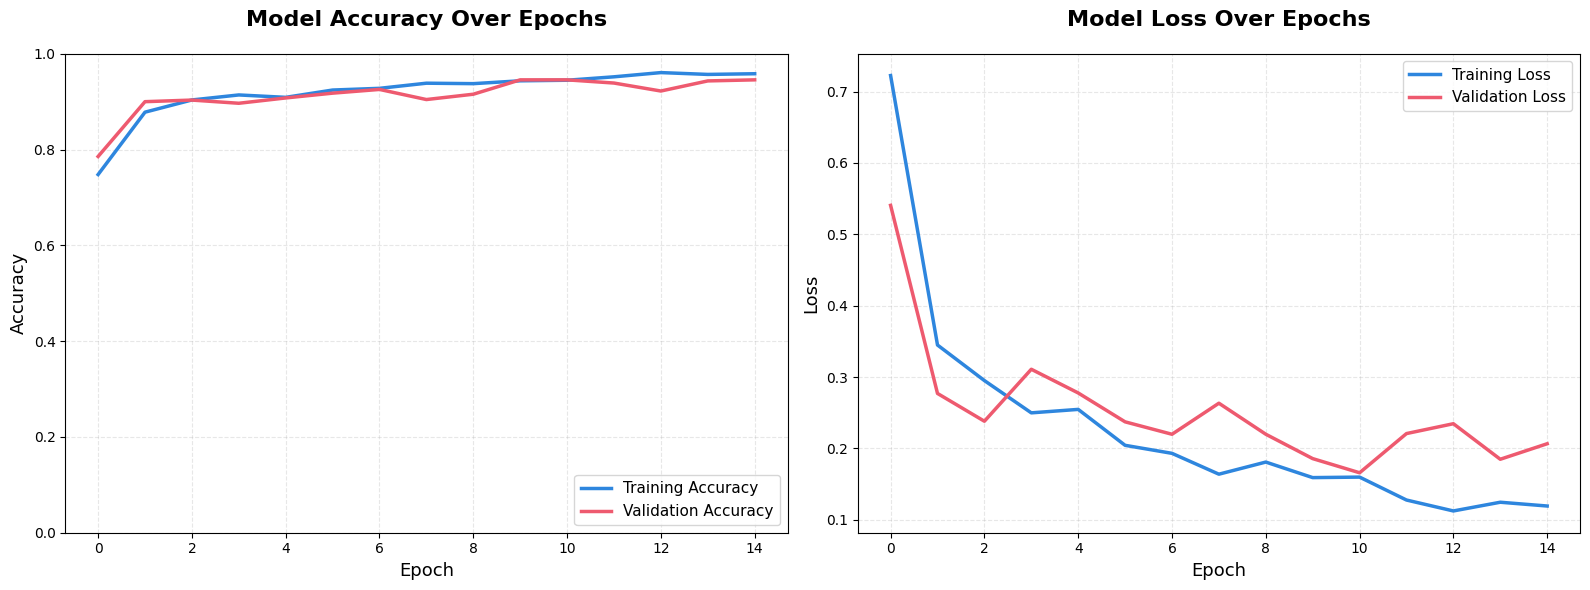

Plot disimpan sebagai 'training_history.png'


In [10]:
# ============================================
# 10. VISUALISASI HASIL TRAINING
# ============================================
print("\n" + "="*50)
print("MEMBUAT PLOT AKURASI DAN LOSS")
print("="*50)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

axes[0].plot(history.history['accuracy'], label='Training Accuracy', linewidth=2.5, color='#2E86DE')
axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2.5, color='#EE5A6F')
axes[0].set_title('Model Accuracy Over Epochs', fontsize=16, fontweight='bold', pad=20)
axes[0].set_xlabel('Epoch', fontsize=13)
axes[0].set_ylabel('Accuracy', fontsize=13)
axes[0].legend(loc='lower right', fontsize=11)
axes[0].grid(True, alpha=0.3, linestyle='--')
axes[0].set_ylim([0, 1])

axes[1].plot(history.history['loss'], label='Training Loss', linewidth=2.5, color='#2E86DE')
axes[1].plot(history.history['val_loss'], label='Validation Loss', linewidth=2.5, color='#EE5A6F')
axes[1].set_title('Model Loss Over Epochs', fontsize=16, fontweight='bold', pad=20)
axes[1].set_xlabel('Epoch', fontsize=13)
axes[1].set_ylabel('Loss', fontsize=13)
axes[1].legend(loc='upper right', fontsize=11)
axes[1].grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()
plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
plt.show()

print("Plot disimpan sebagai 'training_history.png'")

In [11]:
# ============================================
# 11. MENYIMPAN MODEL
# ============================================

print("\n1. Menyimpan dalam format SavedModel...")
model.save('saved_model')
print("   Disimpan di: saved_model/")

print("\n2. Menyimpan dalam format TF-Lite...")
converter = tf.lite.TFLiteConverter.from_saved_model('saved_model')
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

os.makedirs('tflite', exist_ok=True)
with open('tflite/model.tflite', 'wb') as f:
    f.write(tflite_model)
print("   Disimpan di: tflite/model.tflite")

with open('tflite/label.txt', 'w') as f:
    for class_name in sorted(class_indices.keys()):
        f.write(f"{class_name}\n")
print("   Labels disimpan di: tflite/label.txt")


1. Menyimpan dalam format SavedModel...
INFO:tensorflow:Assets written to: saved_model\assets


INFO:tensorflow:Assets written to: saved_model\assets


   Disimpan di: saved_model/

2. Menyimpan dalam format TF-Lite...
   Disimpan di: tflite/model.tflite
   Labels disimpan di: tflite/label.txt


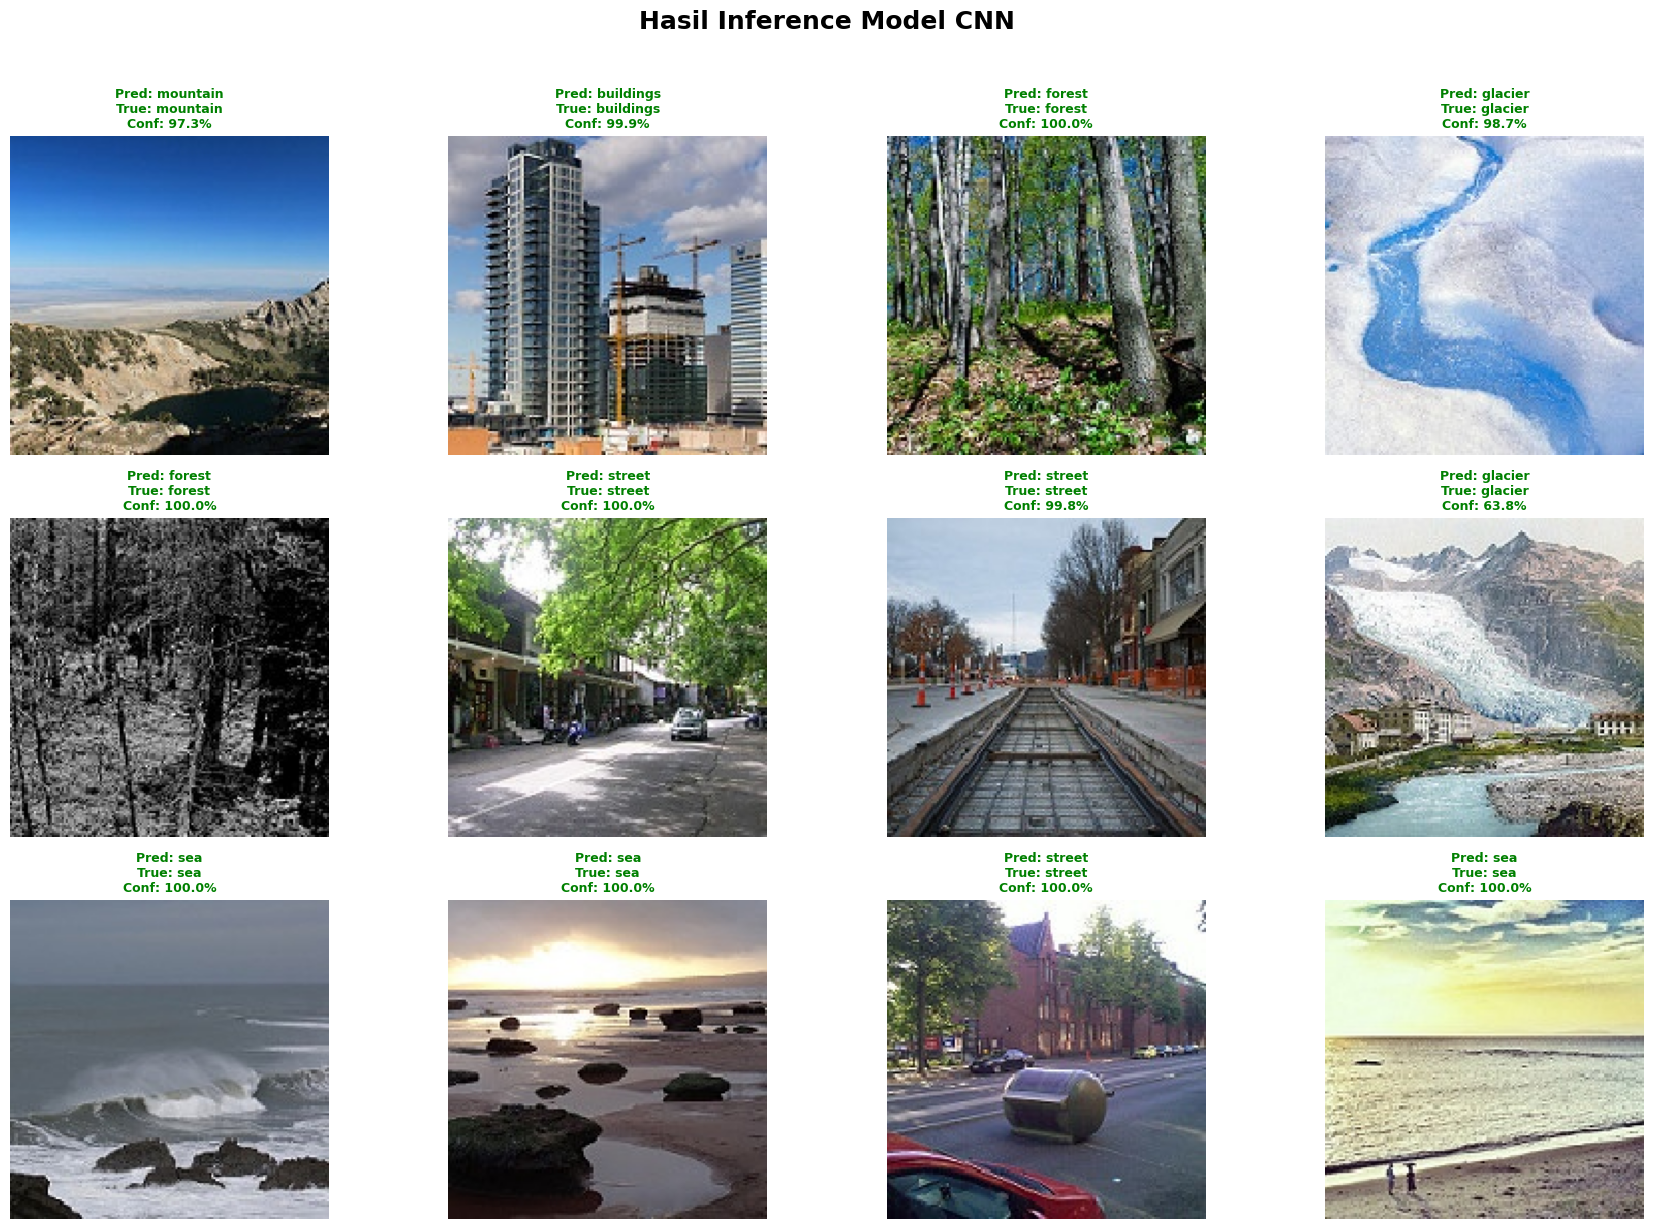

Hasil inference disimpan sebagai 'inference_results.png'


In [12]:
# ============================================
# 12. INFERENCE TEST
# ============================================

sample_images, sample_labels = next(test_generator)
predictions = model.predict(sample_images, verbose=0)

plt.figure(figsize=(18, 12))
for i in range(min(12, len(sample_images))):
    ax = plt.subplot(3, 4, i + 1)
    plt.imshow(sample_images[i])
    
    predicted_idx = np.argmax(predictions[i])
    true_idx = np.argmax(sample_labels[i])
    predicted_class = class_names_dict[predicted_idx]
    true_class = class_names_dict[true_idx]
    confidence = np.max(predictions[i]) * 100
    
    color = 'green' if predicted_class == true_class else 'red'
    
    title = f"Pred: {predicted_class}\nTrue: {true_class}\nConf: {confidence:.1f}%"
    plt.title(title, color=color, fontsize=9, fontweight='bold')
    plt.axis("off")

plt.suptitle("Hasil Inference Model CNN", fontsize=18, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('inference_results.png', dpi=300, bbox_inches='tight')
plt.show()

print("Hasil inference disimpan sebagai 'inference_results.png'")

In [13]:
# ============================================
# 13. INFERENCE DENGAN TF-LITE MODEL
# ============================================
print("\n" + "="*50)
print("INFERENCE DENGAN TF-LITE MODEL")
print("="*50)

interpreter = tf.lite.Interpreter(model_path='tflite/model.tflite')
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print(f"TF-Lite Model Info:")
print(f"   Input shape: {input_details[0]['shape']}")
print(f"   Output shape: {output_details[0]['shape']}")

print("\nTesting TF-Lite Inference...")
test_image = np.expand_dims(sample_images[0], axis=0).astype(np.float32)

interpreter.set_tensor(input_details[0]['index'], test_image)
interpreter.invoke()

tflite_predictions = interpreter.get_tensor(output_details[0]['index'])

predicted_idx = np.argmax(tflite_predictions[0])
predicted_class = class_names_dict[predicted_idx]
confidence = tflite_predictions[0][predicted_idx] * 100
true_class = class_names_dict[np.argmax(sample_labels[0])]

print(f"\nHasil Inference TF-Lite:")
print(f"   True Label: {true_class}")
print(f"   Predicted: {predicted_class}")
print(f"   Confidence: {confidence:.2f}%")
print(f"   Status: {'CORRECT' if predicted_class == true_class else 'WRONG'}")


INFERENCE DENGAN TF-LITE MODEL
TF-Lite Model Info:
   Input shape: [  1 160 160   3]
   Output shape: [1 6]

Testing TF-Lite Inference...

Hasil Inference TF-Lite:
   True Label: mountain
   Predicted: mountain
   Confidence: 98.13%
   Status: CORRECT


In [14]:
# Load model dari H5
print("\n1. Loading best_model.h5...")
model = tf.keras.models.load_model('best_model.h5')
print("   ✓ Model loaded successfully")

# Save sebagai SavedModel
print("\n2. Converting to SavedModel format...")
model.save('saved_model')
print("   ✓ SavedModel saved to: saved_model/")


1. Loading best_model.h5...
   ✓ Model loaded successfully

2. Converting to SavedModel format...
INFO:tensorflow:Assets written to: saved_model\assets


INFO:tensorflow:Assets written to: saved_model\assets


   ✓ SavedModel saved to: saved_model/


In [15]:
import tensorflow as tf
import json
import numpy as np
import os

print("="*60)
print("CREATING TFJS MODEL - Pure Python Method")
print("="*60)

# 1. Create tfjs_model folder
print("\n1. Creating tfjs_model directory...")
os.makedirs('tfjs_model', exist_ok=True)

try:
    model = tf.keras.models.load_model('saved_model')
    print("   ✓ Model loaded successfully")
except:
    print("   ✗ SavedModel not found, trying best_model.h5...")
    model = tf.keras.models.load_model('best_model.h5')
    print("   ✓ Model loaded from H5")

model_json = json.loads(model.to_json())

weights = model.get_weights()

# 5. Create weight specs for manifest
print("\n5. Creating weight specifications...")
weight_specs = []
offset = 0
for i, w in enumerate(weights):
    weight_specs.append({
        "name": f"dense_{i//2}/kernel" if i % 2 == 0 else f"dense_{i//2}/bias",
        "shape": [int(s) for s in w.shape],
        "dtype": "float32"
    })

# 6. Create model.json (TFJS format)
print("\n6. Creating model.json...")
tfjs_model = {
    "format": "layers-model",
    "generatedBy": "keras v2.15.0",
    "convertedBy": "Pure Python Converter",
    "modelTopology": model_json,
    "weightsManifest": [
        {
            "paths": ["group1-shard1of1.bin"],
            "weights": weight_specs
        }
    ]
}

with open('tfjs_model/model.json', 'w') as f:
    json.dump(tfjs_model, f, indent=2)

json_size = os.path.getsize('tfjs_model/model.json') / 1024
print(f"   ✓ model.json saved ({json_size:.2f} KB)")

# 7. Save weights as binary
print("\n7. Saving weights binary...")
# Concatenate all weights and convert to float32 bytes
all_weights = np.concatenate([w.flatten() for w in weights])
weight_bytes = all_weights.astype(np.float32).tobytes()

with open('tfjs_model/group1-shard1of1.bin', 'wb') as f:
    f.write(weight_bytes)

bin_size = os.path.getsize('tfjs_model/group1-shard1of1.bin') / (1024*1024)
print(f"   ✓ group1-shard1of1.bin saved ({bin_size:.2f} MB)")

CREATING TFJS MODEL - Pure Python Method

1. Creating tfjs_model directory...



   ✓ Model loaded successfully

5. Creating weight specifications...

6. Creating model.json...
   ✓ model.json saved (329.40 KB)

7. Saving weights binary...
   ✓ group1-shard1of1.bin saved (14.72 MB)


In [16]:
# ============================================
#RINGKASAN AKHIR PROJECT
# ============================================

print(f"""
DATASET INFORMATION:
   - Source: Kaggle
   - Path: {DATASET_PATH}
   - Total Images: {train_generator.samples + val_generator.samples + test_generator.samples:,} gambar
   - Number of Classes: {num_classes} kelas
   - Image Resolution: Beragam, preprocessing ke {IMG_HEIGHT}x{IMG_WIDTH}
   
DATA SPLIT:
   - Training Set: {train_generator.samples} images (dari seg_train)
   - Validation Set: {val_generator.samples} images (dari seg_train)
   - Test Set: {test_generator.samples} images (dari seg_test)

MODEL PERFORMANCE:
   - Training Accuracy: {train_accuracy*100:.2f}%
   - Validation Accuracy: {val_accuracy*100:.2f}%
   - Test Accuracy: {test_accuracy*100:.2f}%
   - Total Parameters: {total_params:,}

SAVED MODELS:
   - SavedModel -> saved_model/
   - TF-Lite -> tflite/model.tflite
   - TensorFlow.js -> tfjs_model/ (atau model_for_tfjs.h5)

OUTPUT FILES:
   - sample_dataset.png
   - training_history.png
   - inference_results.png
   - best_model.h5
""")

print("="*70)
print("KRITERIA PROJECT - STATUS PEMENUHAN")
print("="*70)

print("\nKRITERIA WAJIB:")
print(f"   - Dataset minimal 1000 gambar: {train_generator.samples + val_generator.samples + test_generator.samples:,} gambar")
print(f"   - Tidak menggunakan RPS/X-Ray: Intel Image Classification")
print(f"   - Split: Train, Val, Test: {train_generator.samples}, {val_generator.samples}, {test_generator.samples}")
print(f"   - Model Sequential + Conv2D + Pooling: 5 Conv Blocks")
print(f"   - Akurasi minimal 85%: Train {train_accuracy*100:.1f}%, Test {test_accuracy*100:.1f}%")
print(f"   - Plot akurasi dan loss: training_history.png")
print(f"   - Export 3 format: SavedModel, TF-Lite, TFJS")

print("\nKRITERIA OPSIONAL:")
print(f"   - Implementasi Callback: 4 callbacks")
print(f"   - Resolusi tidak seragam: Ya")
print(f"   - Dataset >10,000 gambar: {train_generator.samples + val_generator.samples + test_generator.samples:,} gambar")
print(f"   - Akurasi >95%: {'Ya' if train_accuracy >= 0.95 and test_accuracy >= 0.95 else 'Perlu training lebih lama'}")
print(f"   - Minimal 3 kelas: {num_classes} kelas")
print(f"   - Inference dengan model: Keras + TF-Lite")
print(f"   - Bukti inference: inference_results.png")


DATASET INFORMATION:
   - Source: Kaggle
   - Path: D:/classification-images/dataset\datasets\puneet6060\intel-image-classification\versions\2\seg_test\seg_test
   - Total Images: 6,000 gambar
   - Number of Classes: 6 kelas
   - Image Resolution: Beragam, preprocessing ke 160x160
   
DATA SPLIT:
   - Training Set: 4200 images (dari seg_train)
   - Validation Set: 900 images (dari seg_train)
   - Test Set: 900 images (dari seg_test)

MODEL PERFORMANCE:
   - Training Accuracy: 95.17%
   - Validation Accuracy: 94.56%
   - Test Accuracy: 93.89%
   - Total Parameters: 3,859,334

SAVED MODELS:
   - SavedModel -> saved_model/
   - TF-Lite -> tflite/model.tflite
   - TensorFlow.js -> tfjs_model/ (atau model_for_tfjs.h5)

OUTPUT FILES:
   - sample_dataset.png
   - training_history.png
   - inference_results.png
   - best_model.h5

KRITERIA PROJECT - STATUS PEMENUHAN

KRITERIA WAJIB:
   - Dataset minimal 1000 gambar: 6,000 gambar
   - Tidak menggunakan RPS/X-Ray: Intel Image Classification
   